This notebook aims to benchmark wich Julia solver in the most efficient, compared to already implemented OGGM's schemes

In [1]:
# %%
import time
import timeit

import oggm
from oggm import cfg, utils, workflow, tasks, graphics, global_tasks
from oggm.core import flowline, massbalance
import salem
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import functools
from oggm.shop import gcm_climate

cfg.initialize(logging_level='WARNING')

cfg.PARAMS['use_multiprocessing']=False
cfg.PATHS['working_dir'] = '/home/gimenelu/Run_oggm/'
cfg.PARAMS['continue_on_error'] = True

cfg.PARAMS['use_inversion_params_for_run']= True
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5/'

2023-08-21 15:13:57: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-08-21 15:13:57: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-08-21 15:13:57: oggm.cfg: Multiprocessing: using all available processors (N=16)
2023-08-21 15:13:57: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


In [27]:
from juliacall import Main as jl
jl.seval("using Revise")
jl.seval("using Distributed")
jl.seval("using ProgressMeter")
jl.seval("using OrdinaryDiffEq")
jl.seval("using Random")
jl.seval("using SugarBLAS")
jl.seval("using Statistics")
jl.seval("using BenchmarkTools")
jl.seval("using JLD2")
jl.seval("using DataFrames")
jl.seval("using Plots")
jl.seval("using StatsPlots")
jl.seval("using Logging: global_logger")
jl.seval("using TerminalLoggers: TerminalLogger")
jl.seval("using CategoricalArrays")

In [28]:
rgi_ids=["RGI60-11.03638","RGI60-11.03671","RGI60-11.03643","RGI60-11.03674","RGI60-11.03756", #Argentière, Gébroulaz, Mer de Glace,St-Sorlin, Sarennes
    "RGI60-16.00543","RGI60-16.01339", #Zongo, Antizana
    "RGI60-11.03232", #Ossoue
    "RGI60-15.03591", #Mera
    "RGI60-11.03646",
    "RGI60-14.07524", #Siachen
    "RGI60-01.05355"] #Alexander (Alaska)*

ude_solvers = [jl.BS3(),jl.OwrenZen3(),jl.RDPK3Sp35(),jl. ROCK4(), 
               jl.Ralston(),jl.VCABM5(),jl.Vern6()]

#FBDF & QNDF trop long

samples = 10
ny =100
area = []
def BenchmarkingAll(rgi_list,solver_list): #to benchmark all the glaciers from the list on different solvers

    reltol = 1e-5
    
    n = len(rgi_list)
    ude_benchmark = {"id":[], "ude_settings":[], "SemiImp_stats":[], "FluxBased_stats":[]}
    

    
    for r in rgi_list:
        #Initialize glacier
        rgi = [r]
        gdirs=gdirs = workflow.init_glacier_directories(rgi, from_prepro_level=3, prepro_base_url=base_url, prepro_border=80)
        gdir=gdirs[0]
        tasks.init_present_time_glacier(gdir)
        area.append(gdir.rgi_area_km2)
        
        ude_benchmark["id"].append(r)
        
        
        #Benchmarking OGGM schemes 
        cfg.PARAMS["evolution_model"] = "SemiImplicit"

        tico = time.perf_counter()
        for t in range(0,samples): 
            workflow.execute_entity_task(tasks.run_random_climate, gdir, y0 = 2003, nyears=ny,seed=1,store_fl_diagnostics=True,store_model_geometry=True)
        toco = time.perf_counter()

        t_stats_o = (toco-tico)/samples
        ude_benchmark["SemiImp_stats"].append(t_stats_o)  


        cfg.PARAMS["evolution_model"] = "FluxBased"

        tico2 = time.perf_counter()
        for t in range(0,samples):
            workflow.execute_entity_task(tasks.run_random_climate, gdir, y0 = 2003, nyears=ny,seed=1,store_fl_diagnostics=True,store_model_geometry=True)
        toco2 = time.perf_counter()

        t_stats_o2 = (toco2-tico2)/samples
        ude_benchmark["FluxBased_stats"].append(t_stats_o2)  
        
        cfg.PARAMS["evolution_model"] = "SIA1D"
        ude_settings={"solver":[],"time_stats":[]}
        
        for s in solver_list:

            cfg.PARAMS["Julia_solver"] = s

            ude_settings["solver"].append(s)
            ticj = time.perf_counter()
            for t in range(0,samples):
                workflow.execute_entity_task(tasks.run_random_climate, gdir, y0 = 2003, nyears=ny,seed=1,store_fl_diagnostics=True,store_model_geometry=True)
            tocj = time.perf_counter()

            # Save stats for each solver
            t_stats = (tocj - ticj)/samples
            ude_settings["time_stats"].append(t_stats)
        
        ude_benchmark["ude_settings"].append(ude_settings)

    return ude_benchmark



In [29]:
test=BenchmarkingAll(rgi_ids,ude_solvers)

2023-08-21 12:47:02: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2023-08-21 12:47:02: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
/home/gimenelu/oggm/oggm/utils/_workflow.py:2889: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.round(float(_area), decimals=3)
2023-08-21 12:47:03: oggm.cfg: PARAMS['evolution_model'] changed from `SIA1D` to `SemiImplicit`.
2023-08-21 12:47:03: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:47:03: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:47:03: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:47:04: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:47:04: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:47:04:

2023-08-21 12:47:26: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:47:27: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:47:27: oggm.cfg: PARAMS['Julia_solver'] changed from `Ralston(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))` to `VCABM5()`.
2023-08-21 12:47:27: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:47:29: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:47:29: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:47:29: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:47:29: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:47:30: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:47:30: oggm.workflow: Execute entity tasks [run_random_climate] o

2023-08-21 12:47:44: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:47:44: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:47:45: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:47:45: oggm.cfg: PARAMS['Julia_solver'] changed from `RDPK3Sp35(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))` to `ROCK4{Nothing}(0, 152, nothing)`.
2023-08-21 12:47:45: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:47:45: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:47:45: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:47:45: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:47:45: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:47:46: oggm.workflow: Execute entity tas

2023-08-21 12:48:06: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:06: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:06: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:06: oggm.cfg: PARAMS['Julia_solver'] changed from `BS3(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))` to `OwrenZen3(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))`.
2023-08-21 12:48:06: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:06: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:06: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:07: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:07: oggm.workflow: Execute entity tasks [run_random_climate] on 

2023-08-21 12:48:22: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:22: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:23: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:23: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:23: oggm.cfg: PARAMS['evolution_model'] changed from `SemiImplicit` to `FluxBased`.
2023-08-21 12:48:23: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:23: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:23: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:24: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:24: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:24: oggm.workflow: Execute entity tasks [run_random_cl

2023-08-21 12:48:36: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:36: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:36: oggm.cfg: PARAMS['Julia_solver'] changed from `VCABM5()` to `Vern6(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false), lazy = true)`.
2023-08-21 12:48:36: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:37: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:37: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:37: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:37: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:37: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:37: oggm.workflow: Execute entity tasks [run_random

2023-08-21 12:48:49: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:49: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:49: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:49: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:49: oggm.cfg: PARAMS['Julia_solver'] changed from `ROCK4{Nothing}(0, 152, nothing)` to `Ralston(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))`.
2023-08-21 12:48:49: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:50: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:50: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:50: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:48:50: oggm.workflow: Execute entity tasks

2023-08-21 12:49:05: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:49:06: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:49:06: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:49:06: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:49:07: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:49:07: oggm.cfg: PARAMS['Julia_solver'] changed from `OwrenZen3(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))` to `RDPK3Sp35(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))`.
2023-08-21 12:49:07: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:49:07: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:49:07: oggm.workflow: Execute entity tasks [run_random_climat

2023-08-21 12:49:25: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:49:26: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:49:27: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:49:28: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:49:29: oggm.cfg: PARAMS['evolution_model'] changed from `FluxBased` to `SIA1D`.
2023-08-21 12:49:29: oggm.cfg: PARAMS['Julia_solver'] changed from `Vern6(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false), lazy = true)` to `BS3(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))`.
2023-08-21 12:49:29: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:49:29: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:49:29: oggm.workflow: Execute entity tasks [run_random_c

2023-08-21 12:49:43: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:49:44: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:49:44: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:49:44: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2023-08-21 12:49:44: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
/home/gimenelu/oggm/oggm/utils/_workflow.py:2889: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.round(float(_area), decimals=3)
2023-08-21 12:49:44: oggm.cfg: PARAMS['evolution_model'] changed from `SIA1D` to `SemiImplicit`.
2023-08-21 12:49:44: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:49:45: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:49:45:

2023-08-21 12:49:57: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:49:57: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:49:57: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:49:57: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:49:58: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:49:58: oggm.cfg: PARAMS['Julia_solver'] changed from `Ralston(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))` to `VCABM5()`.
2023-08-21 12:49:58: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:49:58: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:49:58: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:49:58: oggm.workflow: Execute entity tasks [run_random_climate] o

2023-08-21 12:50:13: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:50:13: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:50:13: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:50:14: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:50:14: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:50:14: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:50:14: oggm.cfg: PARAMS['Julia_solver'] changed from `RDPK3Sp35(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))` to `ROCK4{Nothing}(0, 152, nothing)`.
2023-08-21 12:50:14: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:50:14: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:50:15: oggm.workflow: Execute entity tas

2023-08-21 12:50:41: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:50:41: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:50:42: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:50:42: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:50:42: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:50:42: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:50:42: oggm.cfg: PARAMS['Julia_solver'] changed from `BS3(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))` to `OwrenZen3(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))`.
2023-08-21 12:50:42: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:50:43: oggm.workflow: Execute entity tasks [run_random_climate] on 

2023-08-21 12:51:00: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:51:00: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:51:01: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:51:02: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:51:02: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:51:03: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:51:03: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:51:04: oggm.cfg: PARAMS['evolution_model'] changed from `SemiImplicit` to `FluxBased`.
2023-08-21 12:51:04: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:51:05: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:51:07: oggm.workflow: Execute entity tasks [run_random_cl

2023-08-21 12:51:37: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:51:37: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:51:38: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:51:38: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:51:38: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:51:39: oggm.cfg: PARAMS['Julia_solver'] changed from `VCABM5()` to `Vern6(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false), lazy = true)`.
2023-08-21 12:51:39: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:51:39: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:51:40: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:51:40: oggm.workflow: Execute entity tasks [run_random

2023-08-21 12:51:54: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:51:54: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:51:54: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:51:54: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:51:55: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:51:55: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:51:55: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:51:55: oggm.cfg: PARAMS['Julia_solver'] changed from `ROCK4{Nothing}(0, 152, nothing)` to `Ralston(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))`.
2023-08-21 12:51:55: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 12:51:55: oggm.workflow: Execute entity tasks

In [ ]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches


f= plt.subplots(figsize=(12, 8))
handles, labels = plt.gca().get_legend_handles_labels()  

ude_solvers_str=["BS3","OwrenZen3","RDPK3Sp35","ROCK4","Ralston","VCABM5","Vern6"]


ng=len(rgi_ids)
ns= len(ude_solvers_str)

mean_si = round(np.mean(test["SemiImp_stats"])*1e3)
mean_fb = round(np.mean(test["FluxBased_stats"])*1e3)
mean_s =np.array([0]*ns)

plt.plot(test["id"],np.array(test["SemiImp_stats"])*1e3,marker='+',color='r',markersize = 10,linestyle='none')

plt.plot(test["id"],np.array(test["FluxBased_stats"])*1e3,marker='+',color='b',markersize = 10,linestyle='none')


plt.xticks(rotation = 70)
plt.ylabel('time [ms]', fontsize = 14)
plt.xlabel('Glacier RGI ID')
colors=["maroon","orange","darkseagreen","cornflowerblue","mediumpurple","lightpink","forestgreen"]

point = Line2D([0], [0], label='Semi Implicit (mean = {} ms)'.format(mean_si), marker='+', markersize=10, 
         markeredgecolor='r', markerfacecolor='r', linestyle='')

point2 = Line2D([0], [0], label='Flux-based (mean = {} ms)'.format(mean_fb), marker='+', markersize=10, 
         markeredgecolor='b', markerfacecolor='b', linestyle='')


for i in range(0,ng):
    for j in range(0,ns):
    
        plt.plot(rgi_ids[i],test["ude_settings"][i]["time_stats"][j]*1e3, marker='o', markersize=6,
             markeredgecolor='w',markerfacecolor=colors[j])
        mean_s[j] += test["ude_settings"][i]["time_stats"][j]*1e3

mean_s = mean_s/ng
handles = [point,point2]
for k in range(0,ns):
    p = Line2D([0], [0], label=ude_solvers_str[k]+' (mean = {} ms)'.format(round(mean_s[k])), marker='o', markersize=6, 
         markeredgecolor='w', markerfacecolor=colors[k], linestyle='')
    handles.append(p)


plt.legend(handles=handles,fontsize=10,loc=2,ncols=2)
#for k in range(0,ng):
#for j in range(0,ns):
        
plt.title('Benchmarking solver for run_random_climate for 100 years')
plt.grid()

In [ ]:
area

In [ ]:
np.array(test["SemiImp_stats"])*1e3

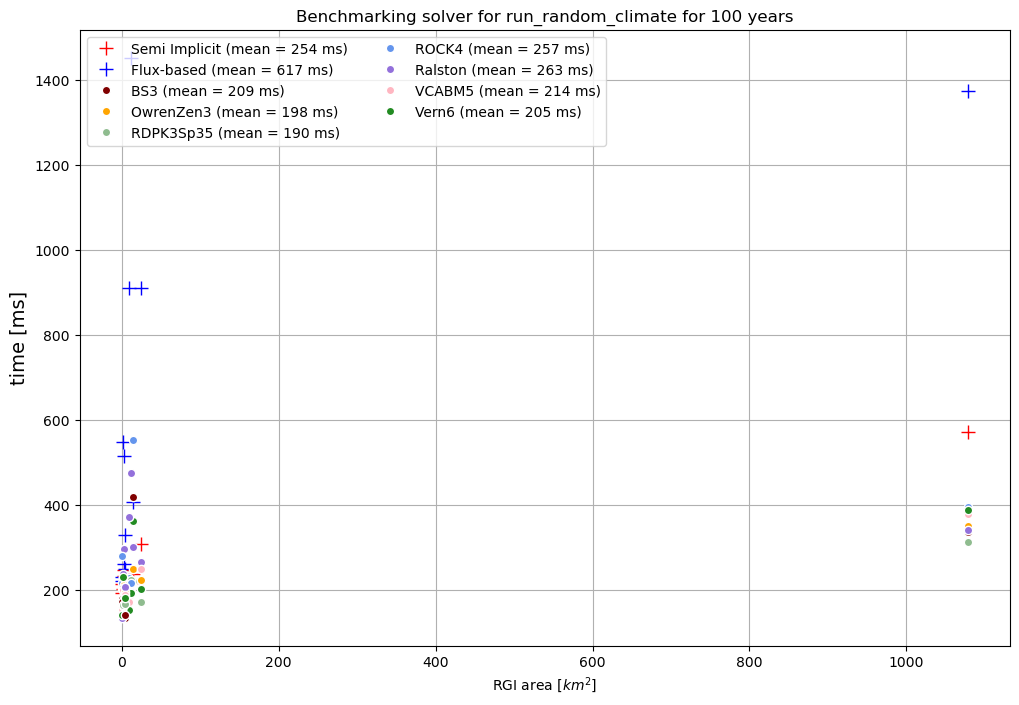

In [74]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


f, ax = plt.subplots(1,1 , sharey=True,figsize=(12, 8))

handles, labels = plt.gca().get_legend_handles_labels()  

ude_solvers_str=["BS3","OwrenZen3","RDPK3Sp35","ROCK4","Ralston","VCABM5","Vern6"]


ng=len(rgi_ids)
ns= len(ude_solvers_str)

mean_si = round(np.mean(test["SemiImp_stats"])*1e3)
mean_fb = round(np.mean(test["FluxBased_stats"])*1e3)
mean_s =np.array([0]*ns)

ax.plot(area,np.array(test["SemiImp_stats"])*1e3,marker='+',color='r',markersize = 10,linestyle='none')

ax.plot(area,np.array(test["FluxBased_stats"])*1e3,marker='+',color='b',markersize = 10,linestyle='none')

ax.set_ylabel('time [ms]', fontsize = 14)
ax.set_xlabel('RGI area [$km^2$]')
colors=["maroon","orange","darkseagreen","cornflowerblue","mediumpurple","lightpink","forestgreen"]

point = Line2D([0], [0], label='Semi Implicit (mean = {} ms)'.format(mean_si), marker='+', markersize=10, 
         markeredgecolor='r', markerfacecolor='r', linestyle='')

point2 = Line2D([0], [0], label='Flux-based (mean = {} ms)'.format(mean_fb), marker='+', markersize=10, 
         markeredgecolor='b', markerfacecolor='b', linestyle='')


for i in range(0,ng):
    for j in range(0,ns):
    
        ax.plot(area[i],test["ude_settings"][i]["time_stats"][j]*1e3, marker='o', markersize=6,
             markeredgecolor='w',markerfacecolor=colors[j])
        mean_s[j] += test["ude_settings"][i]["time_stats"][j]*1e3

mean_s = mean_s/ng
handles = [point,point2]
for k in range(0,ns):
    p = Line2D([0], [0], label=ude_solvers_str[k]+' (mean = {} ms)'.format(round(mean_s[k])), marker='o', markersize=6, 
         markeredgecolor='w', markerfacecolor=colors[k], linestyle='')
    handles.append(p)

ax.legend(handles=handles,fontsize=10,loc=2,ncols=2)
#ax.set_xlim([0,40])   
ax.set_title('Benchmarking solver for run_random_climate for 100 years')
ax.grid()

### Simulation time

In [5]:
rgi_ids=["RGI60-11.03638","RGI60-11.03671","RGI60-11.03643","RGI60-11.03674","RGI60-11.03756", #Argentière, Gébroulaz, Mer de Glace,St-Sorlin, Sarennes
    "RGI60-16.00543","RGI60-16.01339", #Zongo, Antizana
    "RGI60-11.03232", #Ossoue
    "RGI60-15.03591", #Mera
    "RGI60-11.03646",
    "RGI60-14.07524", #Siachen
    "RGI60-01.05355"] #Alexander (Alaska)*


samples = 10
n_list = [50,100,150,200,300,400,500]
ng=len(rgi_ids)
evol_model = ["SemiImplicit", "FluxBased","SIA1D"]

def BenchmarkingTime(rgi_list, filename): #to benchmark all the glaciers from the list on different solvers

    reltol = 1e-5
    
    n = len(rgi_list)
    ude_benchmark = {"id":[], "SemiImplicit":[], "FluxBased":[],"SIA1D":[]}
    

    
    for r in rgi_list:
        #Initialize glacier
        rgi = [r]
        gdirs=gdirs = workflow.init_glacier_directories(rgi, from_prepro_level=3, prepro_base_url=base_url, prepro_border=80)
        gdir=gdirs[0]
        tasks.init_present_time_glacier(gdir)
        
        ude_benchmark["id"].append(r)
        
        
        
        for e in evol_model:
            cfg.PARAMS["evolution_model"] = e
            
            ude_settings={"time_stats":[]}
        
            for y in n_list:

                tico = time.perf_counter()
                for t in range(0,samples): 
                    workflow.execute_entity_task(tasks.run_random_climate, gdir, y0 = 2003, nyears=y,seed=1,store_fl_diagnostics=True,store_model_geometry=True)
                toco = time.perf_counter()

                t_stats_o = (toco-tico)/samples
            
                ude_settings["time_stats"].append(t_stats_o)  
                
            ude_benchmark[e].append(ude_settings)

     
    dfs= []
    for e in evol_model:
        
        df = pd.DataFrame({'rgi_id':[rgi_ids[i] for i in range(0,ng) for j in range(0,len(n_list))],
                           'n_years':n_list*ng,
                            'time_stats':[test2[e][i]['time_stats'][j]for i in range(0,ng) for j in range(0,len(n_list))]})

        df = df.set_index(['rgi_id','n_years']) 
        dfs.append(df)
        
    result = pd.concat(v, axis=1)
    result.columns = evol_model   
    result.to_csv(filename)

In [ ]:
BenchmarkingTime(rgi_ids,'random_climate_time.csv')

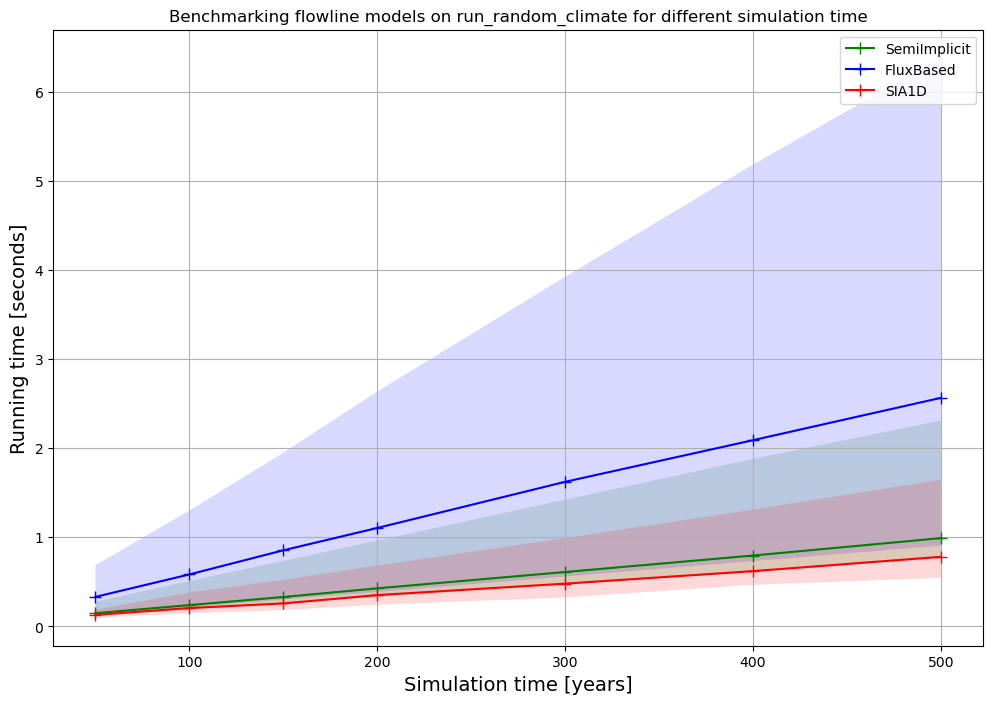

In [6]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches


f, ax = plt.subplots(figsize=(12, 8))
handles, labels = plt.gca().get_legend_handles_labels()  

v=[]

ng=len(rgi_ids)
color_dict = {"SemiImplicit":'g', "FluxBased":'b',"SIA1D":'r'}

evol_model = ["SemiImplicit", "FluxBased","SIA1D"]

df = pd.read_csv('random_climate_time.csv') 
df = df.set_index(['rgi_id','n_years'])


for e in evol_model:
   
    ax.fill_between(n_list, df.groupby(by=['n_years']).min()[e].values,
                    df.groupby(by=['n_years']).max()[e].values, alpha=0.15,
                   color= color_dict[e],edgecolor='none')
    df.groupby(by=['n_years']).mean()[e].plot(ax=ax, marker = '+', markersize= 8,
                                          color=color_dict[e])


    
plt.ylabel('Running time [seconds]', fontsize = 14)
plt.xlabel('Simulation time [years]', fontsize = 14)
plt.title('Benchmarking flowline models on run_random_climate for different simulation time')

point = Line2D([0], [0], label='SemiImplicit',marker='+', markersize=8, color='g',)

point2 = Line2D([0], [0], label='FluxBased', marker='+', markersize=8,color='b')
point3 = Line2D([0], [0], label='SIA1D', marker='+', markersize =8, color='r')

handles = [point,point2, point3]

plt.legend(handles=handles,fontsize=10)

plt.grid()

### Benchmark on the Alps ?

In [6]:
fr = utils.get_rgi_region_file(11)  # Central Europe
gdf = gpd.read_file(fr)
gdf_sel = gdf.loc[gdf.O2Region == '1']

In [7]:
gdf_sel2 = gdf_sel.loc[gdf_sel.Area >=1]

In [8]:
cfg.PARAMS['use_multiprocessing']=True

2023-08-21 11:13:36: oggm.cfg: Multiprocessing switched ON after user settings.


In [9]:
gdirs = workflow.init_glacier_directories(gdf_sel2, prepro_base_url=base_url, from_prepro_level=5)

2023-08-21 11:13:37: oggm.workflow: init_glacier_directories from prepro level 5 on 407 glaciers.
2023-08-21 11:13:37: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 407 glaciers


### trying to achieve an overview benchmark

In [3]:
rgi_ids=["RGI60-11.03638","RGI60-11.03671","RGI60-11.03643","RGI60-11.03674","RGI60-11.03756", #Argentière, Gébroulaz, Mer de Glace,St-Sorlin, Sarennes
    "RGI60-16.00543","RGI60-16.01339", #Zongo, Antizana
    "RGI60-11.03232", #Ossoue
    "RGI60-15.03591", #Mera
    "RGI60-11.03646",
    "RGI60-14.07524", #Siachen
    "RGI60-01.05355"] #Alexander (Alaska)*

In [95]:
samples = 1
n_list = [50,100,150,200,300,400,500]
ng=len(rgi_ids)
evol_model = ["SemiImplicit", "FluxBased","SIA1D"]

def BenchmarkingRandom(rgi_list, filename): #to benchmark all the glaciers from the list on different solvers

    reltol = 1e-5
    
    n = len(rgi_list)
    ude_benchmark = {"id":[], "SemiImplicit":[], "FluxBased":[],"SIA1D":[]}
    
    for r in rgi_list:
        #Initialize glacier
        rgi = [r]
        gdirs = workflow.init_glacier_directories(rgi, from_prepro_level=3, prepro_base_url=base_url, prepro_border=80)
        gdir=gdirs[0]
        tasks.init_present_time_glacier(gdir)
        
        ude_benchmark["id"].append(r)
        
        
        for e in evol_model:
            cfg.PARAMS["evolution_model"] = e
            
            ude_settings={"time_stats":[]}
        
            for y in n_list:

                tico = time.perf_counter()
                for t in range(0,samples): 
                    workflow.execute_entity_task(tasks.run_random_climate, gdir, y0 = 2003, nyears=y,seed=1)
                toco = time.perf_counter()

                t_stats_o = (toco-tico)/samples
            
                ude_settings["time_stats"].append(t_stats_o)  
                
            ude_benchmark[e].append(ude_settings)

    dfs= []
    for e in evol_model:
        
        df = pd.DataFrame({'rgi_id':[rgi_ids[i] for i in range(0,ng) for j in range(0,len(n_list))],
                           'n_years':n_list*ng,
                            'time_stats':[ude_benchmark[e][i]['time_stats'][j]for i in range(0,ng) for j in range(0,len(n_list))]})

        df = df.set_index(['rgi_id','n_years']) 
        dfs.append(df)
        
    result = pd.concat(dfs, axis=1)
    result.columns = evol_model   
    result.to_csv(filename)
    
def BenchmarkingConstant(rgi_list, filename): #to benchmark all the glaciers from the list on different solvers

    reltol = 1e-5
    
    n = len(rgi_list)
    ude_benchmark = {"id":[], "SemiImplicit":[], "FluxBased":[],"SIA1D":[]}
    
    for r in rgi_list:
        #Initialize glacier
        rgi = [r]
        gdirs = workflow.init_glacier_directories(rgi, from_prepro_level=3, prepro_base_url=base_url, prepro_border=80)
        gdir=gdirs[0]
        tasks.init_present_time_glacier(gdir)
        
        ude_benchmark["id"].append(r)
        
        
        for e in evol_model:
            cfg.PARAMS["evolution_model"] = e
            
            ude_settings={"time_stats":[]}
        
            for y in n_list:

                tico = time.perf_counter()
                for t in range(0,samples): 
                    workflow.execute_entity_task(tasks.run_constant_climate, gdir, y0 = 2003, nyears=y)
                toco = time.perf_counter()

                t_stats_o = (toco-tico)/samples
            
                ude_settings["time_stats"].append(t_stats_o)  
                
            ude_benchmark[e].append(ude_settings)

    dfs= []
    for e in evol_model:
        
        df = pd.DataFrame({'rgi_id':[rgi_ids[i] for i in range(0,ng) for j in range(0,len(n_list))],
                           'n_years':n_list*ng,
                            'time_stats':[ude_benchmark[e][i]['time_stats'][j]for i in range(0,ng) for j in range(0,len(n_list))]})

        df = df.set_index(['rgi_id','n_years']) 
        dfs.append(df)
        
    result = pd.concat(dfs, axis=1)
    result.columns = evol_model   
    result.to_csv(filename)
    
    
    
def BenchmarkingClimateData(rgi_list, filename): #to benchmark all the glaciers from the list on different solvers

    reltol = 1e-5
    
    n = len(rgi_list)
    ude_benchmark = {"id":[], "SemiImplicit":[], "FluxBased":[],"SIA1D":[]}
    n_list = [50,100,150,200,250,280]
    
    for r in rgi_list:
        #Initialize glacier
        rgi = [r]
        gdirs = workflow.init_glacier_directories(rgi, from_prepro_level=4, prepro_base_url=base_url, prepro_border=80)
        gdir=gdirs[0]
        tasks.init_present_time_glacier(gdir)
        
        ude_benchmark["id"].append(r)
        
        user ='gimenelu'
        m='MRI-ESM2-0'
        ssp='ssp126'

        fp = '/mnt/{}/equipes/CRYODYN/OGGM/CMIP6-2300/{}_{}_r1i1p1f1_pr.nc'.format(user,m,ssp)
        ft = '/mnt/{}/equipes/CRYODYN/OGGM/CMIP6-2300/{}_{}_r1i1p1f1_tas.nc'.format(user,m,ssp)

        #Bias correction of the files
        workflow.execute_entity_task(gcm_climate.process_cmip_data, gdir, 
                                                 filesuffix='_CMIP6_{}_{}'.format(m,ssp),  # recognize the climate file for later
                                                 fpath_temp=ft,  # temperature projections
                                                 fpath_precip=fp,  # precip projections
                                                 );

        
        for e in evol_model:
            cfg.PARAMS["evolution_model"] = e
            
            ude_settings={"time_stats":[]}
        
            for y in n_list:
                ye = 2020 + y
                tico = time.perf_counter()
                for t in range(0,samples): 
                    
                    sid = '_CMIP6_{}_{}'.format(m,ssp)
                    workflow.execute_entity_task(tasks.run_from_climate_data,gdir,ys=2020,ye=ye,
                                                             climate_filename='gcm_data',  # use gcm_data, not climate_historical
                                                             climate_input_filesuffix=sid,  # use the chosen scenario
                                                             init_model_filesuffix='_historical')
                toco = time.perf_counter()

                t_stats_o = (toco-tico)/samples
            
                ude_settings["time_stats"].append(t_stats_o)  
                
            ude_benchmark[e].append(ude_settings)

    dfs= []
    for e in evol_model:
        
        df = pd.DataFrame({'rgi_id':[rgi_ids[i] for i in range(0,ng) for j in range(0,len(n_list))],
                           'n_years':n_list*ng,
                            'time_stats':[ude_benchmark[e][i]['time_stats'][j]for i in range(0,ng) for j in range(0,len(n_list))]})

        df = df.set_index(['rgi_id','n_years']) 
        dfs.append(df)
        
    result = pd.concat(dfs, axis=1)
    result.columns = evol_model   
    result.to_csv(filename)    
    
def BenchmarkingClimateData_hydro(rgi_list, filename): #to benchmark all the glaciers from the list on different solvers
    
    cfg.PARAMS['store_model_geometry'] = True
    reltol = 1e-5
    
    n = len(rgi_list)
    ude_benchmark = {"id":[], "SemiImplicit":[], "FluxBased":[],"SIA1D":[]}
    n_list = [50,100,150,200,250,280]
    
    for r in rgi_list:
        #Initialize glacier
        rgi = [r]
        gdirs = workflow.init_glacier_directories(rgi, from_prepro_level=4, prepro_base_url=base_url, prepro_border=80)
        gdir=gdirs[0]
        tasks.init_present_time_glacier(gdir)
        
        ude_benchmark["id"].append(r)
        
        user ='gimenelu'
        m='MRI-ESM2-0'
        ssp='ssp126'

        fp = '/mnt/{}/equipes/CRYODYN/OGGM/CMIP6-2300/{}_{}_r1i1p1f1_pr.nc'.format(user,m,ssp)
        ft = '/mnt/{}/equipes/CRYODYN/OGGM/CMIP6-2300/{}_{}_r1i1p1f1_tas.nc'.format(user,m,ssp)

        #Bias correction of the files
        workflow.execute_entity_task(gcm_climate.process_cmip_data, gdir, 
                                                 filesuffix='_CMIP6_{}_{}'.format(m,ssp),  # recognize the climate file for later
                                                 fpath_temp=ft,  # temperature projections
                                                 fpath_precip=fp,  # precip projections
                                                 );

        
        for e in evol_model:
            cfg.PARAMS["evolution_model"] = e
            
            ude_settings={"time_stats":[]}
        
            for y in n_list:
                ye = 2020 + y
                tico = time.perf_counter()
                for t in range(0,samples): 
                    
                    sid = '_CMIP6_{}_{}'.format(m,ssp)
                    workflow.execute_entity_task(tasks.run_with_hydro,gdirs,
                                        run_task=tasks.run_from_climate_data,
                                         ys=2020,ye=ye,
                                         climate_filename='gcm_data',  # use gcm_data, not climate_historical
                                         climate_input_filesuffix=sid,  # use the chosen scenario
                                        init_model_filesuffix='_historical')
                toco = time.perf_counter()

                t_stats_o = (toco-tico)/samples
            
                ude_settings["time_stats"].append(t_stats_o)  
                
            ude_benchmark[e].append(ude_settings)

    dfs= []
    for e in evol_model:
        
        df = pd.DataFrame({'rgi_id':[rgi_ids[i] for i in range(0,ng) for j in range(0,len(n_list))],
                           'n_years':n_list*ng,
                            'time_stats':[ude_benchmark[e][i]['time_stats'][j]for i in range(0,ng) for j in range(0,len(n_list))]})

        df = df.set_index(['rgi_id','n_years']) 
        dfs.append(df)
        
    result = pd.concat(dfs, axis=1)
    result.columns = evol_model   
    result.to_csv(filename)  
    
    
def BenchmarkingSpinup(rgi_list, filename): #to benchmark all the glaciers from the list on different solvers
    
    cfg.PARAMS['store_model_geometry'] = True
    reltol = 1e-5
    
    n = len(rgi_list)
    ude_benchmark = {"id":[], "SemiImplicit":[], "FluxBased":[],"SIA1D":[]}
    n_list = [50,100,150,200,250,280]
    
    for r in rgi_list:
        #Initialize glacier
        rgi = [r]
        gdirs = workflow.init_glacier_directories(rgi, from_prepro_level=4, prepro_base_url=base_url, prepro_border=80)
        gdir=gdirs[0]
        tasks.init_present_time_glacier(gdir)
        
        ude_benchmark["id"].append(r)
        
        user ='gimenelu'
        m='MRI-ESM2-0'
        ssp='ssp126'

        fp = '/mnt/{}/equipes/CRYODYN/OGGM/CMIP6-2300/{}_{}_r1i1p1f1_pr.nc'.format(user,m,ssp)
        ft = '/mnt/{}/equipes/CRYODYN/OGGM/CMIP6-2300/{}_{}_r1i1p1f1_tas.nc'.format(user,m,ssp)

        #Bias correction of the files
        workflow.execute_entity_task(gcm_climate.process_cmip_data, gdir, 
                                                 filesuffix='_CMIP6_{}_{}'.format(m,ssp),  # recognize the climate file for later
                                                 fpath_temp=ft,  # temperature projections
                                                 fpath_precip=fp,  # precip projections
                                                 );

        
        for e in evol_model:
            cfg.PARAMS["evolution_model"] = e
            
            ude_settings={"time_stats":[]}
        
            for y in n_list:
                ye = 1950 + y
                tico = time.perf_counter()
                for t in range(0,samples): 
                    
                    sid = '_CMIP6_{}_{}'.format(m,ssp)
                    workflow.execute_entity_task(tasks.run_from_climate_data,gdir,
                                        fixed_geometry_spinup_yr=1950, ye=ye,
                                         climate_filename='gcm_data',  # use gcm_data, not climate_historical
                                         climate_input_filesuffix=sid)
                    
                toco = time.perf_counter()

                t_stats_o = (toco-tico)/samples
            
                ude_settings["time_stats"].append(t_stats_o)  
                
            ude_benchmark[e].append(ude_settings)

    dfs= []
    for e in evol_model:
        
        df = pd.DataFrame({'rgi_id':[rgi_ids[i] for i in range(0,ng) for j in range(0,len(n_list))],
                           'n_years':n_list*ng,
                            'time_stats':[ude_benchmark[e][i]['time_stats'][j]for i in range(0,ng) for j in range(0,len(n_list))]})

        df = df.set_index(['rgi_id','n_years']) 
        dfs.append(df)
        
    result = pd.concat(dfs, axis=1)
    result.columns = evol_model   
    result.to_csv(filename)    

In [85]:
BenchmarkingRandom(rgi_ids,'random.csv')

2023-08-21 13:52:57: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2023-08-21 13:52:57: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2023-08-21 13:52:57: oggm.cfg: PARAMS['evolution_model'] changed from `SIA1D` to `SemiImplicit`.
2023-08-21 13:52:57: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:52:58: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:52:58: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:52:58: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:52:59: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:52:59: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:53:00: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:53:01: oggm.cfg: PARAMS['evolution_model'] changed from `Se

2023-08-21 13:53:44: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:53:44: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:53:44: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:53:44: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:53:45: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:53:45: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:53:46: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:53:47: oggm.cfg: PARAMS['evolution_model'] changed from `FluxBased` to `SIA1D`.
2023-08-21 13:53:47: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:53:47: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:53:47: oggm.workflow: Execute entity tasks [run_random_climate] 

2023-08-21 13:54:27: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:54:27: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:54:27: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:54:28: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:54:28: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2023-08-21 13:54:28: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2023-08-21 13:54:29: oggm.cfg: PARAMS['evolution_model'] changed from `SIA1D` to `SemiImplicit`.
2023-08-21 13:54:29: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:54:29: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:54:29: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:54:29: oggm.workflow: Execute entity tasks [run_random_clim

2023-08-21 13:55:21: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:55:23: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:55:25: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:55:27: oggm.cfg: PARAMS['evolution_model'] changed from `SemiImplicit` to `FluxBased`.
2023-08-21 13:55:27: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:55:28: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:55:29: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:55:31: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:55:34: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:55:37: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers
2023-08-21 13:55:42: oggm.workflow: Execute entity tasks [run_random_cl

In [88]:
BenchmarkingConstant(rgi_ids,'constant.csv')

2023-08-21 14:00:26: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2023-08-21 14:00:26: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2023-08-21 14:00:26: oggm.cfg: PARAMS['evolution_model'] changed from `SIA1D` to `SemiImplicit`.
2023-08-21 14:00:26: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2023-08-21 14:00:26: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2023-08-21 14:00:26: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2023-08-21 14:00:27: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2023-08-21 14:00:27: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2023-08-21 14:00:28: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2023-08-21 14:00:28: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2023-08-21 14:00:29: oggm.cfg: PARAMS['evolution_model'] ch

2023-08-21 14:01:11: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2023-08-21 14:01:12: oggm.cfg: PARAMS['evolution_model'] changed from `SemiImplicit` to `FluxBased`.
2023-08-21 14:01:12: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2023-08-21 14:01:12: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2023-08-21 14:01:12: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2023-08-21 14:01:12: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2023-08-21 14:01:13: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2023-08-21 14:01:13: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2023-08-21 14:01:14: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2023-08-21 14:01:15: oggm.cfg: PARAMS['evolution_model'] changed from `FluxBased` to `SIA1D`.
2023-08-21 14:01:15: oggm.workflow: Execute entity ta

2023-08-21 14:01:47: oggm.cfg: PARAMS['evolution_model'] changed from `FluxBased` to `SIA1D`.
2023-08-21 14:01:47: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2023-08-21 14:01:47: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2023-08-21 14:01:47: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2023-08-21 14:01:47: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2023-08-21 14:01:47: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2023-08-21 14:01:47: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2023-08-21 14:01:48: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2023-08-21 14:01:48: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2023-08-21 14:01:48: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2023-08-21 14:01:49: oggm.cfg: PARAMS['evolution_model'] chang

2023-08-21 14:02:35: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2023-08-21 14:02:36: oggm.cfg: PARAMS['evolution_model'] changed from `SIA1D` to `SemiImplicit`.
2023-08-21 14:02:36: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2023-08-21 14:02:36: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2023-08-21 14:02:36: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2023-08-21 14:02:37: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2023-08-21 14:02:38: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2023-08-21 14:02:40: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2023-08-21 14:02:41: oggm.workflow: Execute entity tasks [run_constant_climate] on 1 glaciers
2023-08-21 14:02:44: oggm.cfg: PARAMS['evolution_model'] changed from `SemiImplicit` to `FluxBased`.
2023-08-21 14:02:44: oggm.workflow: Execute entity tas

In [92]:
BenchmarkingClimateData(rgi_ids,'climatedata.csv')

2023-08-21 14:14:27: oggm.workflow: init_glacier_directories from prepro level 4 on 1 glaciers.
2023-08-21 14:14:27: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2023-08-21 14:14:31: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2023-08-21 14:14:49: oggm.cfg: PARAMS['evolution_model'] changed from `SIA1D` to `SemiImplicit`.
2023-08-21 14:14:49: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:14:49: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:14:49: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:14:49: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:14:50: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:14:50: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:14:51: oggm.cfg: PARAMS['evolution_model']

2023-08-21 14:16:09: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:16:10: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:16:10: oggm.cfg: PARAMS['evolution_model'] changed from `FluxBased` to `SIA1D`.
2023-08-21 14:16:10: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:16:10: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:16:11: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:16:11: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:16:11: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:16:11: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:16:12: oggm.workflow: init_glacier_directories from prepro level 4 on 1 glaciers.
2023-08-21 14:16:12: oggm.workflow: Execute entity

2023-08-21 14:17:55: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:17:55: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:17:56: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:17:56: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:17:56: oggm.cfg: PARAMS['evolution_model'] changed from `SemiImplicit` to `FluxBased`.
2023-08-21 14:17:56: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:17:56: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:17:57: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:17:57: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:17:57: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:17:58: oggm.workflow: Execute 

2023-08-21 14:19:32: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:19:33: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:19:34: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:19:34: oggm.workflow: init_glacier_directories from prepro level 4 on 1 glaciers.
2023-08-21 14:19:34: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2023-08-21 14:19:39: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2023-08-21 14:19:58: oggm.cfg: PARAMS['evolution_model'] changed from `SIA1D` to `SemiImplicit`.
2023-08-21 14:19:58: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:19:58: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:19:58: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:19:59: oggm.workflow: Execute entity tasks

In [94]:
BenchmarkingClimateData_hydro(rgi_ids,'climatedata_hydro.csv')

2023-08-21 14:24:34: oggm.workflow: init_glacier_directories from prepro level 4 on 1 glaciers.
2023-08-21 14:24:34: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2023-08-21 14:24:34: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2023-08-21 14:24:53: oggm.cfg: PARAMS['evolution_model'] changed from `SIA1D` to `SemiImplicit`.
2023-08-21 14:24:53: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21 14:24:53: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21 14:24:53: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21 14:24:53: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21 14:24:54: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21 14:24:54: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21 14:24:55: oggm.cfg: PARAMS['evolution_model'] changed from `SemiImplicit` to `FluxBased

2023-08-21 14:26:19: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21 14:26:19: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21 14:26:20: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21 14:26:20: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21 14:26:21: oggm.workflow: init_glacier_directories from prepro level 4 on 1 glaciers.
2023-08-21 14:26:21: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2023-08-21 14:26:21: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2023-08-21 14:26:39: oggm.cfg: PARAMS['evolution_model'] changed from `SIA1D` to `SemiImplicit`.
2023-08-21 14:26:39: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21 14:26:40: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21 14:26:40: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21

2023-08-21 14:28:05: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21 14:28:06: oggm.cfg: PARAMS['evolution_model'] changed from `FluxBased` to `SIA1D`.
2023-08-21 14:28:06: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21 14:28:06: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21 14:28:07: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21 14:28:07: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21 14:28:07: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21 14:28:07: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21 14:28:08: oggm.workflow: init_glacier_directories from prepro level 4 on 1 glaciers.
2023-08-21 14:28:08: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2023-08-21 14:28:08: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2023-08-21 14

2023-08-21 14:30:02: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21 14:30:03: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21 14:30:03: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21 14:30:03: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21 14:30:04: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21 14:30:05: oggm.cfg: PARAMS['evolution_model'] changed from `FluxBased` to `SIA1D`.
2023-08-21 14:30:05: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21 14:30:05: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21 14:30:05: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21 14:30:06: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21 14:30:06: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-21 14:30:06: oggm.

In [96]:
BenchmarkingSpinup(rgi_ids,'fixedspinup.csv')

2023-08-21 14:37:53: oggm.workflow: init_glacier_directories from prepro level 4 on 1 glaciers.
2023-08-21 14:37:53: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2023-08-21 14:37:54: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2023-08-21 14:38:12: oggm.cfg: PARAMS['evolution_model'] changed from `SIA1D` to `SemiImplicit`.
2023-08-21 14:38:12: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:38:12: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:38:12: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:38:13: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:38:13: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:38:13: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:38:14: oggm.cfg: PARAMS['evolution_model']

2023-08-21 14:39:01: oggm.cfg: PARAMS['evolution_model'] changed from `SemiImplicit` to `FluxBased`.
2023-08-21 14:39:01: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:39:01: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:39:01: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:39:02: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:39:02: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:39:03: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:39:04: oggm.cfg: PARAMS['evolution_model'] changed from `FluxBased` to `SIA1D`.
2023-08-21 14:39:04: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:39:05: oggm.core.flowline: JuliaError occurred during task flowline_model_run on RGI60-11.03643: BoundsError: attempt to acces

2023-08-21 14:39:49: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:39:49: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:39:49: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:39:49: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:39:50: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:39:50: oggm.workflow: init_glacier_directories from prepro level 4 on 1 glaciers.
2023-08-21 14:39:50: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2023-08-21 14:39:50: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2023-08-21 14:40:08: oggm.cfg: PARAMS['evolution_model'] changed from `SIA1D` to `SemiImplicit`.
2023-08-21 14:40:08: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:40:08: oggm.workflow: Execute entity tasks

2023-08-21 14:40:55: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:40:55: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:40:55: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:40:56: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:40:56: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:40:56: oggm.cfg: PARAMS['evolution_model'] changed from `SemiImplicit` to `FluxBased`.
2023-08-21 14:40:56: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:40:56: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:40:57: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:40:57: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:40:57: oggm.workflow: Execute 

2023-08-21 14:41:47: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:41:50: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:41:52: oggm.cfg: PARAMS['evolution_model'] changed from `FluxBased` to `SIA1D`.
2023-08-21 14:41:52: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:41:53: oggm.core.flowline: JuliaError occurred during task flowline_model_run on RGI60-11.03646: BoundsError: attempt to access 51-element Vector{Union{Float64, Py}} at index [52]
Stacktrace:
 [1] setindex!
   @ ./array.jl:966 [inlined]
 [2] update_diag!(diag_jl::diag, SIA1D::Py, l_var::PyList{Any}, dyn_spin_thick::Float64, j::Int64)
   @ Main ~/oggm/oggm/core/SIA1D.jl:138
 [3] diag(nₜm::Int64, fac::Int64, diff::Int64, SIA1D::Py, l_var::PyList{Any}, dyn_spin_thick::Float64)
   @ Main ~/oggm/oggm/core/SIA1D.jl:130
 [4] glacier_evolution_store(; SIA1D::Py, solver::Vern6{typeof(OrdinaryDiffEq.trivial_li

2023-08-21 14:42:42: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:42:42: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:42:43: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:42:43: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-21 14:42:43: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers


In [51]:
dfs[-1].iloc[:,0].index.values

array([ 50, 100, 150, 200, 250, 280])

/tmp/ipykernel_23901/3170669956.py:46: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(dfm.index.values[y],dfm.values[y],marker=marker_dict[evol_model[i]],
/tmp/ipykernel_23901/3170669956.py:46: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(dfm.index.values[y],dfm.values[y],marker=marker_dict[evol_model[i]],
/tmp/ipykernel_23901/3170669956.py:46: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(dfm.index.values[y],dfm.values[y],marker=marker_dict[evol_model[i]],
/tmp/ipykernel_23901/3170669956.py:46: UserWarning: You passed a edgec

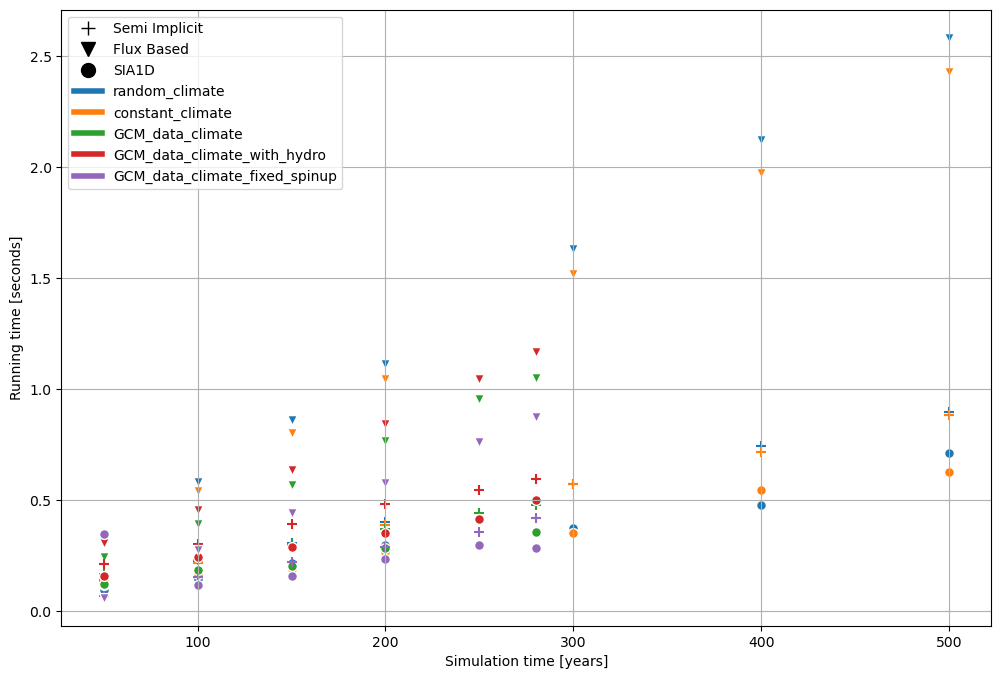

In [72]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches


f, ax = plt.subplots(figsize=(12, 8))
handles, labels = plt.gca().get_legend_handles_labels()  

ng=len(rgi_ids)
marker_dict =  {"SemiImplicit":'+', "FluxBased":'v',"SIA1D":'o'}

point = Line2D([0], [0], label='Semi Implicit', marker='+', markersize=10, 
         markeredgecolor='k', markerfacecolor='k', linestyle='')

point2 = Line2D([0], [0], label='Flux Based', marker='v', markersize=10, 
         markeredgecolor='k', markerfacecolor='k', linestyle='')

point3 = Line2D([0], [0], label='SIA1D', marker='o', markersize=10, 
         markeredgecolor='k', markerfacecolor='k', linestyle='')

handles=[point, point2, point3]

evol_model = ["SemiImplicit", "FluxBased","SIA1D"]
nm = len(evol_model)

tasks = ['random', 'constant', 'climatedata','climatedata_hydro','fixedspinup']

tasks_dict = {'random':'tab:blue', 'constant':'tab:orange', 'climatedata':'tab:green',
              'climatedata_hydro':'tab:red','fixedspinup':'tab:purple'}

tasks_label = ['random_climate', 'constant_climate', 'GCM_data_climate','GCM_data_climate_with_hydro',
            'GCM_data_climate_fixed_spinup']


dfs = []
custom_lines = []
for task in tasks:

    df = pd.read_csv('{}.csv'.format(task)) 
    df = df.set_index(['rgi_id','n_years'])
    df2 = df.groupby(by=['n_years']).mean()
    dfs.append(df2)
    
    for i in range(0,nm):
        dfm = df2.iloc[:,i]
        for y in range(0,len(dfm)):
            ax.scatter(dfm.index.values[y],dfm.values[y],marker=marker_dict[evol_model[i]],
                       c = tasks_dict[task],s=50,edgecolors='w')
    
    l = Line2D([0], [0], color=tasks_dict[task], lw=4, label = tasks_label[tasks.index(task)])
    custom_lines.append(l)
    
    
    
ax.legend(handles=handles+custom_lines)  
ax.set_xlabel('Simulation time [years]')
ax.set_ylabel('Running time [seconds]')
ax.grid()